In [256]:
import matplotlib.pyplot as plt
import numpy as np
import csv
import pandas as pd
import torch
import torch.nn as nn
import rsample_dataset
from torch.utils.data import DataLoader
import seaborn as sns

In [77]:
DSET_TYPE = "U"
N = 500
M = 2
CP=41

with open(f"{DSET_TYPE}_{N}_M{M}.csv") as f:
    reader = csv.reader(f)
    data = list(reader)

[t_losses, v_losses, t_accuracies, v_accuracies] = data
t_losses = [float(x) for x in t_losses]
v_losses = [float(x) for x in v_losses]
t_accuracies = [float(x) for x in t_accuracies]
v_accuracies = [float(x) for x in v_accuracies]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,

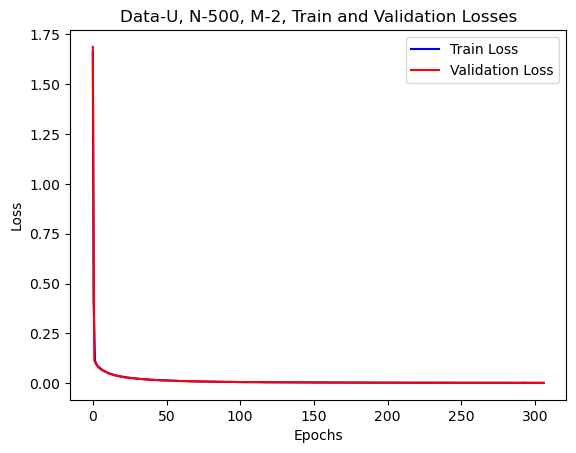

In [78]:
len_x = len(v_losses)
val_x = [i for i in range(0, len_x)]
train_x = [i/2 for i in range(0, len_x*2-1)]
print(val_x, train_x)

# Plot the train and validation losses
plt.plot(train_x,t_losses, label='Train Loss', color='blue')
plt.plot(val_x, v_losses, label='Validation Loss', color='red')

# Set labels and title for the plot
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title(f'Data-{DSET_TYPE}, N-{N}, M-{M}, Train and Validation Losses')

# Add legend and show plot
plt.legend()
plt.show()


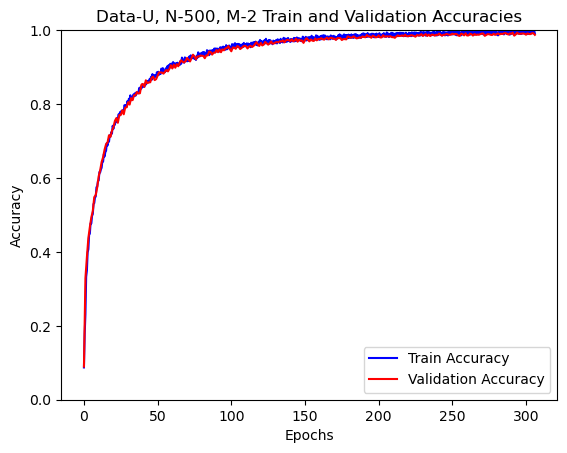

In [79]:
# Plot the train and validation accuracies
plt.plot(train_x,t_accuracies, label='Train Accuracy', color='blue')
plt.plot(val_x, v_accuracies, label='Validation Accuracy', color='red')

# Set labels and title for the plot
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title(f'Data-{DSET_TYPE}, N-{N}, M-{M} Train and Validation Accuracies')
plt.ylim(0, 1)

# Add legend and show plot
plt.legend()
plt.show()


## M=2 Accuracy Analyses

In [209]:
CP = 21

class SimpleNet(nn.Module):
    def __init__(self, input_size, num_classes):
        super(SimpleNet, self).__init__()
        self.fc1 = nn.Linear(input_size, 100)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(100, num_classes)  # Output logits, not probabilities

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        # x = self.dropout(x)
        x = self.fc2(x)
        return x

model = SimpleNet(input_size=1781, num_classes=N)

# evaluating checkpoints
checkpoint = torch.load(f'checkpoints/M{M}_cp{CP}.pth')
model.load_state_dict(checkpoint['model_state_dict'])


data = pd.read_csv(f"../data_binary.csv")

In [210]:
len(data.iloc[1, 5:])

1781

In [263]:
# Prepare data for final evaluation of model
datafile = 'data/B_500.pkl'
indexfile = f'indices/{DSET_TYPE}_{N}_test.idx'
# test_set = dataset.LazyChemDataset(datafile, indexfile, M, N, transform=AddGaussianNoise())

class AddGaussianNoise(object):
    """Add Gaussian noise to a tensor."""
    def __init__(self, mean=0.1, std=0.01):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Adds Gaussian noise to a tensor.
        """
        noise = np.random.randn(1781) * self.std + self.mean
        return tensor + noise

test_set = rsample_dataset.RSampleDataset(
    pickle_file=datafile,
    index_file=indexfile,
    n_mixture=M,
    num_classes=N,
    transform=AddGaussianNoise(),
    total_samples=10000,
)

test_loader = DataLoader(test_set, batch_size=64, shuffle=True)

In [266]:
classes = data['type'].unique()
zipped_sim_acc = []
class_accuracies = {(c1, c2): 0.0 for c1 in classes for c2 in classes}
class_counts = {(c1, c2): 0 for c1 in classes for c2 in classes}

In [267]:
# accuracy function
def accuracy_fn(y_pred, y_true):
    top_n_preds = y_pred.topk(M)[1]
    for i in range(len(y_true)):
        true_indices = y_true[i].nonzero()
        true_indices = true_indices.view(-1)
        if (len(true_indices) < M):
            continue
        accuracy = true_indices.sort()[0].eq(top_n_preds[i].sort()[0]).sum().item()/M

        # calculate jaccard similarity
        x = np.array(data.iloc[true_indices[0].item(), 5:])
        y = np.array(data.iloc[true_indices[1].item(), 5:])
        intersection = np.logical_and(x, y).sum()
        union = np.logical_or(x, y).sum()
        jaccard_similarity = 0 if union == 0 else intersection/union

        # calculate dot prod similarity
        dot_prod_similarity = np.dot(x, y)/1781

        zipped_sim_acc.append((accuracy, dot_prod_similarity))
        # print(accuracy, dot_prod_similarity)

        # update class accuracies
        c1 = data.iloc[true_indices[0].item(), :]['type']
        c2 = data.iloc[true_indices[1].item(), :]['type']
        class_accuracies[(c1, c2)] += accuracy
        class_accuracies[(c2, c1)] += accuracy
        class_counts[(c1, c2)] += 1
        class_counts[(c2, c1)] += 1


# Accuracy measure function
def top_n_accuracy(preds, labels, n=M, correct_n=M):
    """
    Calculate the top-n accuracy for the given predictions and labels.
    """
    top_n_preds = preds.topk(n, dim=1)[1]  # Returns values and indices; [1] to get indices
    
    # Initialize the score
    score = 0.0

    for i in range(labels.size(0)):
        actual_labels = labels[i].bool()
        # select the label positions that are top n
        correct_preds = actual_labels[top_n_preds[i]].float()  
        score += correct_preds.sum().item() / correct_n

    return score


In [268]:
# Testing loop
def test():
    running_correct = 0.0

    # Loop through test_loader
    for mix, label in test_loader:
        if not mix.shape:  # Skip batches that somehow have no data
            continue
        outputs = model(mix).squeeze(1)
        predicted_probs = torch.sigmoid(outputs)
        
        running_correct += top_n_accuracy(predicted_probs, label)
        
        accuracy_fn(predicted_probs, label)

    # Calculate overall accuracy and F1 score
    accuracy = running_correct / len(test_loader.dataset)

    print(f"Overall Accuracy: {accuracy:.4f}")
    return accuracy

Overall Accuracy: 0.7503


Text(0, 0.5, 'Accuracy')

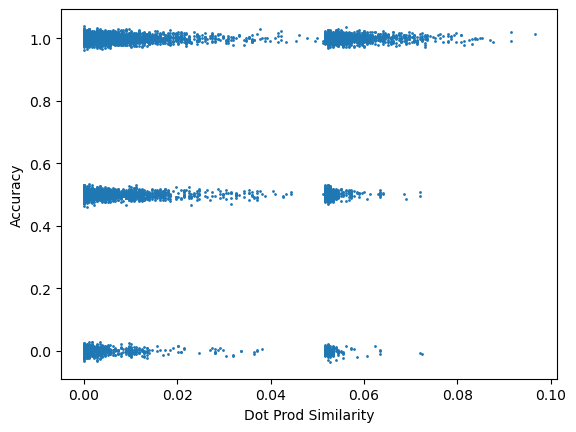

In [269]:
test()

acc, sim = zip(*zipped_sim_acc)
jitter_strength = 0.01
acc_jittered = np.array(acc) + np.random.normal(0, jitter_strength, len(acc))

plt.scatter(sim, acc_jittered, s=1)
plt.xlabel('Dot Prod Similarity')
plt.ylabel('Accuracy')

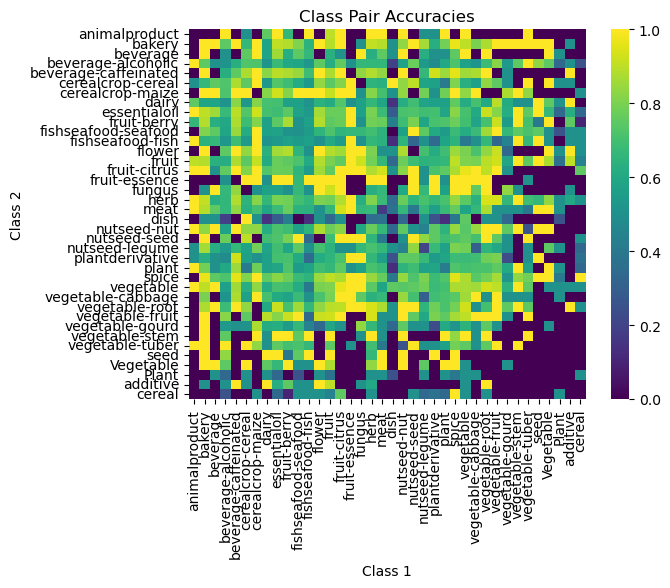

In [270]:
# normalize class_accuracies with class_counts and make a heatmap
for k in class_accuracies.keys():
    if class_counts[k] > 0:
        class_accuracies[k] /= class_counts[k]

class_accuracies = np.array([[class_accuracies[(c1, c2)] for c2 in classes] for c1 in classes])
sns.heatmap(class_accuracies, xticklabels=classes, yticklabels=classes, cmap='viridis')
plt.xlabel('Class 1')
plt.ylabel('Class 2')
plt.title('Class Pair Accuracies')
plt.show()
